In [159]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from IPython.core.interactiveshell import InteractiveShell
from sklearn.model_selection import KFold
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline
sns.set()
pd.options.display.max_rows = 100

<h4>Importing Old Dataset</h4>

In [160]:
# Import dataset and clean, ready as a dataframe for creating keys
def createDF(datasets):
    df = pd.read_csv(datasets, converters={'PARTY_ID': str, 'COM_ID': str, 'CNTR_SIZE': str})

    # Formating to type and remove NaN values
    df['POD'] = pd.to_datetime(df['POD'])
    df['ENCODED_TYPE'] = df['ENCODED_TYPE'].fillna(-1).astype(int)
    df = df.dropna(subset=['ENCODED_TYPE'])
    df['RATE'] = df['RATE'].fillna(-1).astype(float)
    df = df.dropna(subset=['RATE'])
    df['ENCODED_TYPE'] = df['ENCODED_TYPE'].astype(int)
    df_clean= df.dropna().reset_index(drop=True)

    # Selecting and rearranging columns
    sel_col = ['CSL_ID', 'CNTR_ID','POD_ID','ETD_POL_D','PARTY_ID',
            'PARTY_NAME','POD','CNTR_SIZE','CNTR_TYPE','RATE']
    df_fc = df_clean[sel_col]

    # Removing years we do not want to process in our models
    df_filtered = df_fc[df_fc['POD'].dt.year != 2002]

    # Sorting the dates
    df_filtered = df_filtered.sort_values(by='POD').reset_index(drop=True)
    
    return df_filtered

In [161]:
# Create Dataframes
old_data = '.\Datasets\CR_COST_FC.csv'
df1 = createDF(old_data)
df1.head()
df1.info()


,CSL_ID,CNTR_ID,POD_ID,ETD_POL_D,PARTY_ID,PARTY_NAME,POD,CNTR_SIZE,CNTR_TYPE,RATE
0,ECS01050600224,CTNR010050700354,ROTTERDAM,NLRTM,01008827,YANG MING (SINGAPORE) PTE. LTD.,2005-07-15,40,HC NOR,1620.0
1,ECS01050600610,CTNR010050700353,FELIXSTOWE,GBFXT,01002303,GLOBELINK FALLOW LIMITED,2005-07-15,40,GP,1800.0
2,ECS01050600041,CTNR010050700351,AUCKLAND,NZAKL,01005136,MONDIALE FREIGHT SERVICES LIMITED-AUCKLAND,2005-07-15,40,HC NOR,2170.0
3,ECS01050600163,CTNR010050700370,PASIR GUDANG,MYPGU,01002767,GLOBELINK CONTAINER LINES (JB) S/B,2005-07-15,40,HC,280.0
4,ECS01050600456,CTNR010050700450,KARACHI (KICT),PKKHI,01002783,GLOBELINK PAKISTAN (PVT) LTD,2005-07-16,40,HC,1625.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54082 entries, 0 to 54081
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   CSL_ID      54082 non-null  object        
 1   CNTR_ID     54082 non-null  object        
 2   POD_ID      54082 non-null  object        
 3   ETD_POL_D   54082 non-null  object        
 4   PARTY_ID    54082 non-null  object        
 5   PARTY_NAME  54082 non-null  object        
 6   POD         54082 non-null  datetime64[ns]
 7   CNTR_SIZE   54082 non-null  object        
 8   CNTR_TYPE   54082 non-null  object        
 9   RATE        54082 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(8)
memory usage: 4.1+ MB


In [162]:
new_data = '.\Datasets\CR_COST_FC_new.csv'
df2 = createDF(new_data)
df2.head()
df2.info()

,CSL_ID,CNTR_ID,POD_ID,ETD_POL_D,PARTY_ID,PARTY_NAME,POD,CNTR_SIZE,CNTR_TYPE,RATE
0,ECS01050600224,CTNR010050700354,ROTTERDAM,NLRTM,01008827,YANG MING (SINGAPORE) PTE. LTD.,2005-07-15,40,HC NOR,1620.0
1,ECS01050600610,CTNR010050700353,FELIXSTOWE,GBFXT,01002303,GLOBELINK FALLOW LIMITED,2005-07-15,40,GP,1800.0
2,ECS01050600041,CTNR010050700351,AUCKLAND,NZAKL,01005136,MONDIALE FREIGHT SERVICES LIMITED-AUCKLAND,2005-07-15,40,HC NOR,2170.0
3,ECS01050600163,CTNR010050700370,PASIR GUDANG,MYPGU,01002767,GLOBELINK CONTAINER LINES (JB) S/B,2005-07-15,40,HC,280.0
4,ECS01050600456,CTNR010050700450,KARACHI (KICT),PKKHI,01002783,GLOBELINK PAKISTAN (PVT) LTD,2005-07-16,40,HC,1625.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54721 entries, 0 to 54720
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   CSL_ID      54721 non-null  object        
 1   CNTR_ID     54721 non-null  object        
 2   POD_ID      54721 non-null  object        
 3   ETD_POL_D   54721 non-null  object        
 4   PARTY_ID    54721 non-null  object        
 5   PARTY_NAME  54721 non-null  object        
 6   POD         54721 non-null  datetime64[ns]
 7   CNTR_SIZE   54721 non-null  object        
 8   CNTR_TYPE   54721 non-null  object        
 9   RATE        54721 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(8)
memory usage: 4.2+ MB


<h4>Creating Dictionary Keys</h4>

In [163]:
def filter_dataframe(df):
    filtered_dataframes = {}

    for (port, size, ctype, party_id), group in df.groupby(['POD_ID', 'CNTR_SIZE', 'CNTR_TYPE', 'PARTY_ID']):
        group = group.reset_index(drop=True).sort_values(by='POD')
        df_id = f"Port_{port}_Size_{size}_Type_{ctype}_PartyID_{party_id}"
        filtered_dataframes[df_id] = group

    return filtered_dataframes

In [164]:
filtered_dataframe1 = filter_dataframe(df1)
df_ids1 = list(filtered_dataframe1.keys())
print(list(df_ids1))
print(len(list(df_ids1)))

['Port_(CONSTANZA)_Size_40_Type_GP_PartyID_010007816', 'Port_(CONSTANZA)_Size_40_Type_HC_PartyID_010007816', 'Port_AARHUS_Size_20_Type_GP_PartyID_01000043', 'Port_AARHUS_Size_20_Type_GP_PartyID_0100027830', 'Port_AARHUS_Size_20_Type_GP_PartyID_010006666', 'Port_AARHUS_Size_40_Type_GP_PartyID_01000043', 'Port_AARHUS_Size_40_Type_HC_PartyID_01000043', 'Port_AARHUS_Size_40_Type_HC_PartyID_0100027830', 'Port_AARHUS_Size_40_Type_HC_PartyID_0100028193', 'Port_AARHUS_Size_40_Type_HC_PartyID_010006666', 'Port_ABIDJAN_Size_20_Type_GP_PartyID_0100027878', 'Port_ABIDJAN_Size_40_Type_HC_PartyID_010021097', 'Port_ADELAIDE_Size_20_Type_GP_PartyID_01002775', 'Port_ADELAIDE_Size_40_Type_GP_PartyID_01002775', 'Port_ADELAIDE_Size_40_Type_HC_PartyID_01002775', 'Port_ADELAIDE_Size_40_Type_HC_PartyID_01005078', 'Port_ADELAIDE_Size_40_Type_HC NOR_PartyID_01002775', 'Port_ADELAIDE(AU)_Size_20_Type_GP_PartyID_01002775', 'Port_ADELAIDE(AU)_Size_40_Type_HC_PartyID_01002775', 'Port_ADELAIDE(AU)_Size_40_Type_HC N

In [165]:
filtered_dataframe2 = filter_dataframe(df2)
df_ids2 = list(filtered_dataframe2.keys())
print(list(df_ids2))
print(len(list(df_ids2)))

['Port_(CONSTANZA)_Size_40_Type_GP_PartyID_010007816', 'Port_(CONSTANZA)_Size_40_Type_HC_PartyID_010007816', 'Port_AARHUS_Size_20_Type_GP_PartyID_01000043', 'Port_AARHUS_Size_20_Type_GP_PartyID_0100027830', 'Port_AARHUS_Size_20_Type_GP_PartyID_0100028193', 'Port_AARHUS_Size_20_Type_GP_PartyID_010006666', 'Port_AARHUS_Size_40_Type_GP_PartyID_01000043', 'Port_AARHUS_Size_40_Type_HC_PartyID_01000043', 'Port_AARHUS_Size_40_Type_HC_PartyID_0100027830', 'Port_AARHUS_Size_40_Type_HC_PartyID_0100028193', 'Port_AARHUS_Size_40_Type_HC_PartyID_010006666', 'Port_ABIDJAN_Size_20_Type_GP_PartyID_0100027878', 'Port_ABIDJAN_Size_40_Type_HC_PartyID_010021097', 'Port_ADELAIDE_Size_20_Type_GP_PartyID_01002775', 'Port_ADELAIDE_Size_40_Type_GP_PartyID_01002775', 'Port_ADELAIDE_Size_40_Type_HC_PartyID_01002775', 'Port_ADELAIDE_Size_40_Type_HC_PartyID_01005078', 'Port_ADELAIDE_Size_40_Type_HC NOR_PartyID_01002775', 'Port_ADELAIDE(AU)_Size_20_Type_GP_PartyID_01002775', 'Port_ADELAIDE(AU)_Size_40_Type_HC_Party

<h4>Getting Top 5 ports keys</h4>

Getting only the top 5 ports as there are substantial data for training, testing and forecasting. I named it as keybunch as there are many keys for one dataset.

In [166]:
def getTop5Ports(keybunch):
    keybunch_pouch = []
    
    # Get a dictionary with key and number of rows for each dataframe in filtered_dataframes
    key_row_counts = {key: len(keybunch[key]) for key in keybunch}

    # Sort the key_row_counts dictionary by value (number of rows) in descending order
    sorted_key_row_counts = sorted(key_row_counts.items(), key=lambda item: item[1], reverse=True)

    # Get the top 5 keys with the most rows
    top_5_keys_tuple = sorted_key_row_counts[:5]

    # Create a dictionary with the top 5 keys and their corresponding dataframes (with up to 5 rows per dataframe)
    keybunch_subset = {}

    for key, row_count in top_5_keys_tuple:
        keybunch_subset[key] = keybunch[key][:5]
        print(f"Number of rows in {key}: {row_count}")
        keybunch_pouch.append(key)
    
    # Return array of keys
    return keybunch_pouch


In [167]:
print('Old Dataset Keybunch:')
old_df = getTop5Ports(filtered_dataframe1)
print('\n')

print('New Dataset Keybunch:')
new_df = getTop5Ports(filtered_dataframe2)

Old Dataset Keybunch:
Number of rows in Port_BUSAN_Size_40_Type_HC_PartyID_010004286: 1689
Number of rows in Port_AUCKLAND_Size_40_Type_HC_PartyID_01005136: 1688
Number of rows in Port_MELBOURNE_Size_40_Type_HC_PartyID_01002778: 1325
Number of rows in Port_SYDNEY_Size_40_Type_HC_PartyID_01002779: 1300
Number of rows in Port_DUBAI (JEBEL ALI)_Size_40_Type_HC_PartyID_01002788: 1052


New Dataset Keybunch:
Number of rows in Port_BUSAN_Size_40_Type_HC_PartyID_010004286: 1712
Number of rows in Port_AUCKLAND_Size_40_Type_HC_PartyID_01005136: 1704
Number of rows in Port_MELBOURNE_Size_40_Type_HC_PartyID_01002778: 1341
Number of rows in Port_SYDNEY_Size_40_Type_HC_PartyID_01002779: 1308
Number of rows in Port_DUBAI (JEBEL ALI)_Size_40_Type_HC_PartyID_01002788: 1070


<h4>Working with one, the highest count</h4>

In [168]:
# Accessing the highest count in the each keypouch, new and old.
sel_df = filtered_dataframe1[old_df[0]]
sel_df.tail(5)

latest_sel_df = filtered_dataframe2[new_df[0]]
latest_sel_df.tail(5)

,CSL_ID,CNTR_ID,POD_ID,ETD_POL_D,PARTY_ID,PARTY_NAME,POD,CNTR_SIZE,CNTR_TYPE,RATE
1684,ECS010230100126,010000391908,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2023-02-22,40,HC,300.0
1685,ECS010230100126,010000380884,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2023-02-22,40,HC,300.0
1687,ECS010230100127,010000407833,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2023-02-28,40,HC,300.0
1686,ECS010230100127,010000390366,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2023-02-28,40,HC,300.0
1688,ECS010230100127,010000401385,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2023-02-28,40,HC,300.0


,CSL_ID,CNTR_ID,POD_ID,ETD_POL_D,PARTY_ID,PARTY_NAME,POD,CNTR_SIZE,CNTR_TYPE,RATE
1708,ECS010230300113,010000512466,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2023-05-03,40,HC,260.0
1707,ECS010230300113,010000534846,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2023-05-03,40,HC,260.0
1709,ECS010230400203,010000544930,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2023-05-10,40,HC,300.0
1710,ECS010230400183,010000565100,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2023-05-17,40,HC,260.0
1711,ECS010230400183,010000554335,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2023-05-17,40,HC,260.0


<h4>Latest datapoints from Latest dataframe.</h4>

In [169]:
# Get the maximum date in the old dataframe
max_date_in_old = sel_df['POD'].max()

# Create a new dataframe that only includes rows from the latest dataframe where the date is greater than the maximum date in the old dataframe
new_dates_df = latest_sel_df[latest_sel_df['POD'] > max_date_in_old].reset_index(drop=True)

# Print the new dataframe
new_dates_df.head()
new_dates_df.info()

,CSL_ID,CNTR_ID,POD_ID,ETD_POL_D,PARTY_ID,PARTY_NAME,POD,CNTR_SIZE,CNTR_TYPE,RATE
0,ECS010230200077,010000419950,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2023-03-08,40,HC,260.0
1,ECS010230200077,010000406570,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2023-03-08,40,HC,260.0
2,ECS010230200078,010000432251,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2023-03-15,40,HC,260.0
3,ECS010230200078,010000425766,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2023-03-15,40,HC,260.0
4,ECS010230200248,010000444765,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2023-03-19,40,HC,300.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23 entries, 0 to 22
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   CSL_ID      23 non-null     object        
 1   CNTR_ID     23 non-null     object        
 2   POD_ID      23 non-null     object        
 3   ETD_POL_D   23 non-null     object        
 4   PARTY_ID    23 non-null     object        
 5   PARTY_NAME  23 non-null     object        
 6   POD         23 non-null     datetime64[ns]
 7   CNTR_SIZE   23 non-null     object        
 8   CNTR_TYPE   23 non-null     object        
 9   RATE        23 non-null     float64       
dtypes: datetime64[ns](1), float64(1), object(8)
memory usage: 1.9+ KB


<h4>Start to prepare dataframe for LSTM and ARIMA<h4>

In [170]:
grouped_df = sel_df.groupby(['POD', 'RATE']).size().reset_index(name='Count')
sorted_df = grouped_df.sort_values(by='Count', ascending=False)
sorted_df.head(10)
sorted_df.info()


,POD,RATE,Count
961,2021-02-07,20.0,6
973,2021-03-27,120.0,5
1002,2021-07-21,300.0,5
1057,2022-03-04,750.0,5
907,2020-07-02,50.0,5
1008,2021-08-20,300.0,4
927,2020-09-16,50.0,4
931,2020-10-02,150.0,4
935,2020-10-18,50.0,4
938,2020-11-03,50.0,4


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1126 entries, 961 to 563
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   POD     1126 non-null   datetime64[ns]
 1   RATE    1126 non-null   float64       
 2   Count   1126 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 35.2 KB


In [171]:
# Remove duplicated dates and cost rows
sel_df = sel_df.drop_duplicates(subset=['POD', 'RATE']).reset_index(drop=True)

# Remove features that are not important
sel_feat = ['POD','RATE']
sel_df = sel_df[sel_feat]

sel_df.head(10)
sel_df.info()


,POD,RATE
0,2005-10-03,390.0
1,2005-10-07,390.0
2,2005-10-14,390.0
3,2005-10-30,390.0
4,2005-11-03,390.0
5,2005-11-12,390.0
6,2005-11-28,390.0
7,2005-12-04,390.0
8,2005-12-10,390.0
9,2005-12-31,390.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1126 entries, 0 to 1125
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   POD     1126 non-null   datetime64[ns]
 1   RATE    1126 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 17.7 KB


In [172]:
# Interpolate using spline interpolation

# Create a new dataframe with a date range from min to max date in your dataframe
new_df = pd.DataFrame()
new_df['POD'] = pd.date_range(start=sel_df['POD'].min(), end=sel_df['POD'].max())

# Merge the original dataframe with the new one. Missing dates in the original dataframe will be filled with NaN
df_interpolated = pd.merge(new_df, sel_df, on='POD', how='left')

# Perform spline interpolation
df_interpolated['RATE'] = df_interpolated['RATE'].interpolate(method='spline', order=2)

df_interpolated.head(10)
df_interpolated.info()

,POD,RATE
0,2005-10-03,390.0
1,2005-10-04,390.0
2,2005-10-05,390.0
3,2005-10-06,390.0
4,2005-10-07,390.0
5,2005-10-08,390.0
6,2005-10-09,390.0
7,2005-10-10,390.0
8,2005-10-11,390.0
9,2005-10-12,390.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 6376 entries, 0 to 6375
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   POD     6376 non-null   datetime64[ns]
 1   RATE    6376 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 149.4 KB


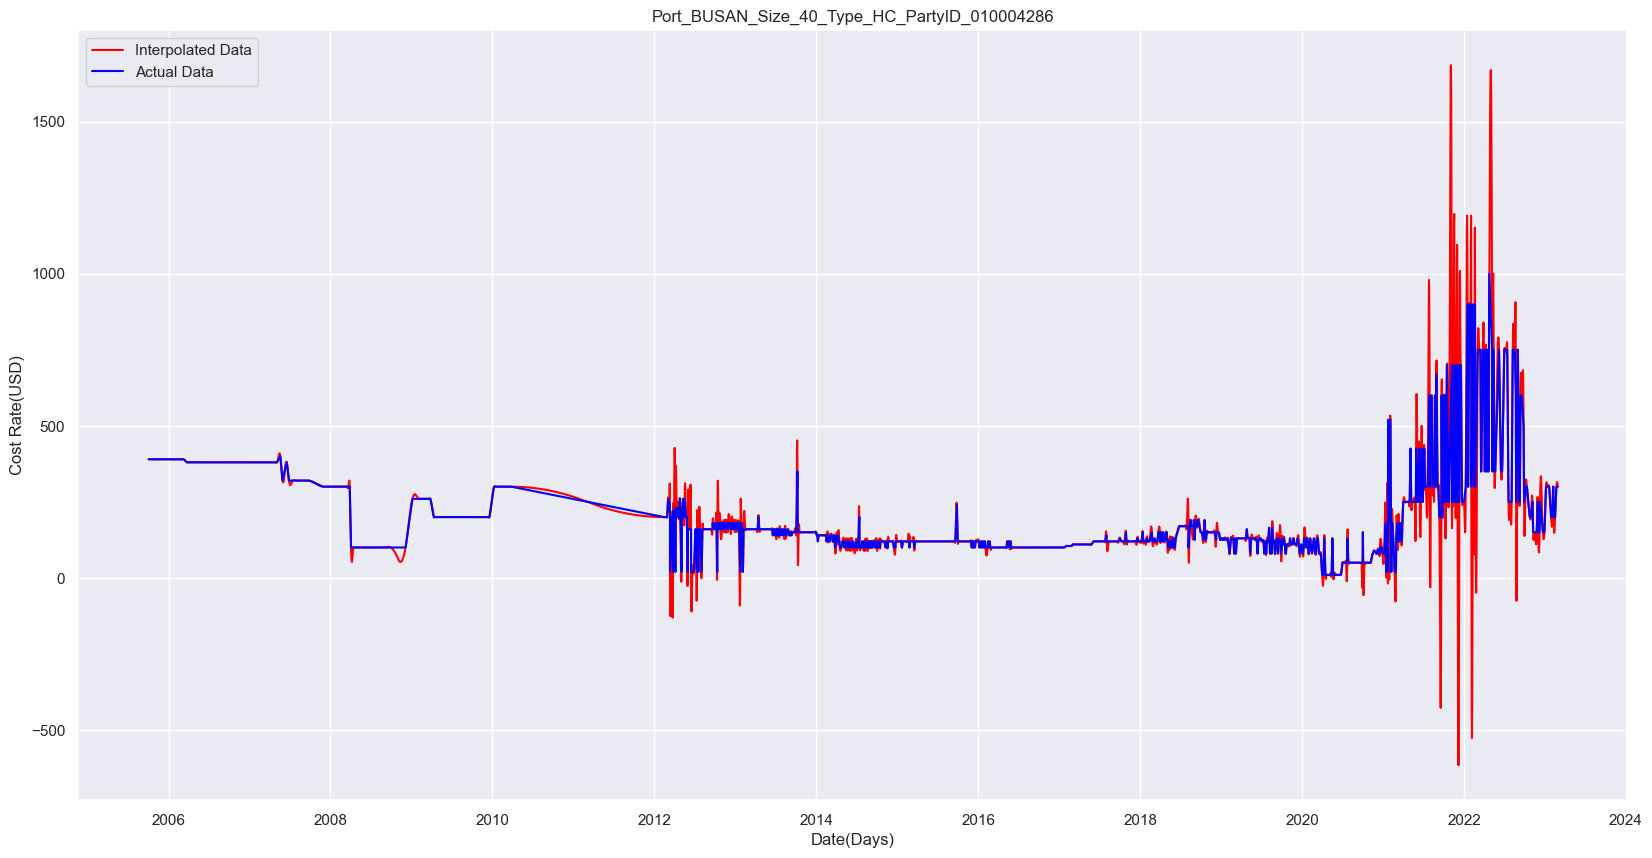

In [173]:
plt.figure(figsize=(20, 10))
plt.plot(df_interpolated['POD'], df_interpolated['RATE'], color='red', label="Interpolated Data")
plt.plot(sel_df['POD'], sel_df['RATE'], color='blue', label="Actual Data")

plt.xlabel('Date(Days)')
plt.ylabel('Cost Rate(USD)')
plt.title(old_df[0])
plt.legend()
plt.show();

<h4>Mean Square Error Evaluation Function</h4>

In [174]:
# Mean Square Error Function:
def calculate_RMSE(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

<h4>LSTM Regression<h4>

In [175]:
# Restructure time series data for LSTM model
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

def create_LSTM_model(trainX, trainY, testX, testY, epochs):
    # LSTM model
    model = Sequential()
    model.add(LSTM(4, input_shape=(trainX.shape[1], trainX.shape[2]), activation='tanh', recurrent_activation='hard_sigmoid'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')

    # Fit the model and store the history
    history = model.fit(trainX, trainY, epochs=epochs, batch_size=1, verbose=2, validation_data=(testX, testY))
    return model, history

# To see if overfitting, underfitting or good fit
def plot_train_val_loss(history):
    plt.figure(figsize=(10,6))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model loss progress during training and validation')
    plt.xlabel('Epoch')
    plt.ylabel('Training and Validation Loss')
    plt.legend()
    plt.show()

Training for 10 epochs...
Epoch 1/10
4461/4461 - 8s - loss: 0.0020 - val_loss: 0.0013 - 8s/epoch - 2ms/step
Epoch 2/10
4461/4461 - 7s - loss: 6.0347e-05 - val_loss: 0.0010 - 7s/epoch - 1ms/step
Epoch 3/10
4461/4461 - 6s - loss: 4.4733e-05 - val_loss: 0.0010 - 6s/epoch - 1ms/step
Epoch 4/10
4461/4461 - 6s - loss: 4.6094e-05 - val_loss: 0.0010 - 6s/epoch - 1ms/step
Epoch 5/10
4461/4461 - 7s - loss: 4.6491e-05 - val_loss: 0.0010 - 7s/epoch - 1ms/step
Epoch 6/10
4461/4461 - 7s - loss: 4.5274e-05 - val_loss: 9.9605e-04 - 7s/epoch - 1ms/step
Epoch 7/10
4461/4461 - 6s - loss: 4.5183e-05 - val_loss: 0.0011 - 6s/epoch - 1ms/step
Epoch 8/10
4461/4461 - 7s - loss: 4.5988e-05 - val_loss: 0.0010 - 7s/epoch - 1ms/step
Epoch 9/10
4461/4461 - 6s - loss: 4.5958e-05 - val_loss: 0.0010 - 6s/epoch - 1ms/step
Epoch 10/10
4461/4461 - 7s - loss: 4.5631e-05 - val_loss: 9.9989e-04 - 7s/epoch - 1ms/step


Text(0.5, 1.0, 'Model loss progress during training and validation')

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Training and Validation Loss')

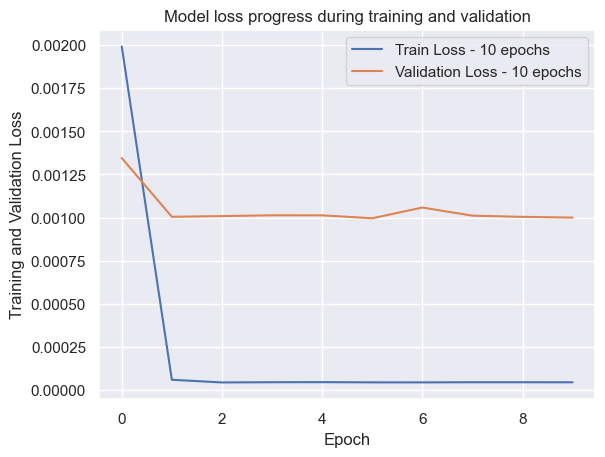

60/60 [==============================] - 0s 966us/step
Train Score: 15.83 RMSE for 10 epochs
Test Score: 72.77 RMSE for 10 epochs
Training for 30 epochs...
Epoch 1/30
4461/4461 - 9s - loss: 0.0021 - val_loss: 0.0012 - 9s/epoch - 2ms/step
Epoch 2/30
4461/4461 - 7s - loss: 5.4967e-05 - val_loss: 9.9583e-04 - 7s/epoch - 1ms/step
Epoch 3/30
4461/4461 - 6s - loss: 4.7226e-05 - val_loss: 9.8970e-04 - 6s/epoch - 1ms/step
Epoch 4/30
4461/4461 - 7s - loss: 4.7103e-05 - val_loss: 0.0010 - 7s/epoch - 2ms/step
Epoch 5/30
4461/4461 - 7s - loss: 4.6757e-05 - val_loss: 9.8534e-04 - 7s/epoch - 1ms/step
Epoch 6/30
4461/4461 - 6s - loss: 4.7298e-05 - val_loss: 9.8866e-04 - 6s/epoch - 1ms/step
Epoch 7/30
4461/4461 - 6s - loss: 4.5735e-05 - val_loss: 9.8580e-04 - 6s/epoch - 1ms/step
Epoch 8/30
4461/4461 - 6s - loss: 4.5268e-05 - val_loss: 9.9033e-04 - 6s/epoch - 1ms/step
Epoch 9/30
4461/4461 - 6s - loss: 4.6973e-05 - val_loss: 9.8910e-04 - 6s/epoch - 1ms/step
Epoch 10/30
4461/4461 - 6s - loss: 4.6335e-05 

Text(0.5, 1.0, 'Model loss progress during training and validation')

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Training and Validation Loss')

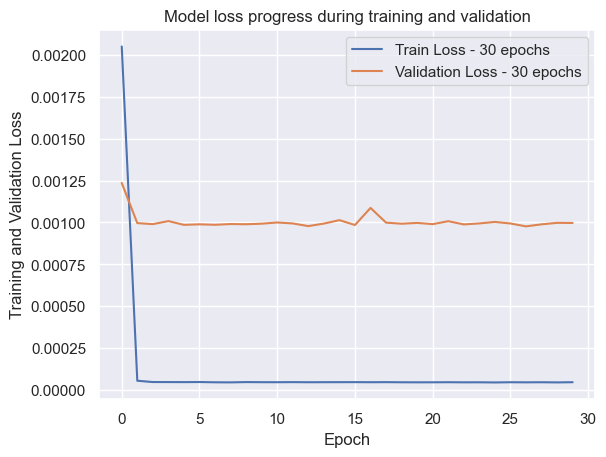

60/60 [==============================] - 0s 932us/step
Train Score: 15.52 RMSE for 30 epochs
Test Score: 72.65 RMSE for 30 epochs
Training for 50 epochs...
Epoch 1/50
4461/4461 - 8s - loss: 0.0023 - val_loss: 0.0017 - 8s/epoch - 2ms/step
Epoch 2/50
4461/4461 - 7s - loss: 7.1636e-05 - val_loss: 9.9036e-04 - 7s/epoch - 2ms/step
Epoch 3/50
4461/4461 - 7s - loss: 4.6776e-05 - val_loss: 0.0010 - 7s/epoch - 1ms/step
Epoch 4/50
4461/4461 - 7s - loss: 4.5633e-05 - val_loss: 0.0010 - 7s/epoch - 2ms/step
Epoch 5/50
4461/4461 - 7s - loss: 4.6368e-05 - val_loss: 0.0010 - 7s/epoch - 2ms/step
Epoch 6/50
4461/4461 - 7s - loss: 4.5567e-05 - val_loss: 0.0010 - 7s/epoch - 2ms/step
Epoch 7/50
4461/4461 - 7s - loss: 4.6260e-05 - val_loss: 9.9331e-04 - 7s/epoch - 1ms/step
Epoch 8/50
4461/4461 - 7s - loss: 4.6190e-05 - val_loss: 9.8638e-04 - 7s/epoch - 2ms/step
Epoch 9/50
4461/4461 - 7s - loss: 4.6012e-05 - val_loss: 0.0010 - 7s/epoch - 1ms/step
Epoch 10/50
4461/4461 - 7s - loss: 4.6587e-05 - val_loss: 9.94

Text(0.5, 1.0, 'Model loss progress during training and validation')

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Training and Validation Loss')

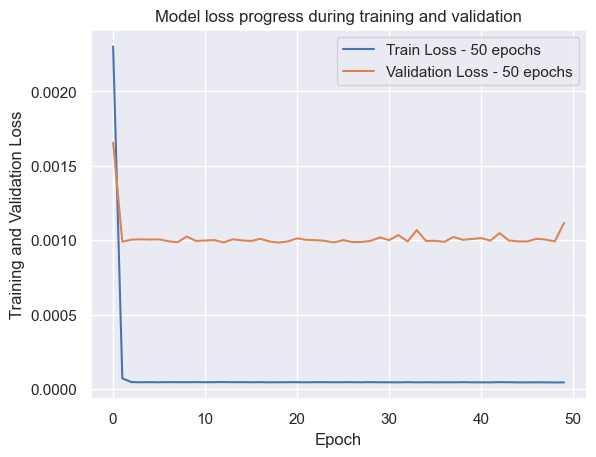

60/60 [==============================] - 0s 952us/step
Train Score: 23.81 RMSE for 50 epochs
Test Score: 76.89 RMSE for 50 epochs
Training for 100 epochs...
Epoch 1/100
4461/4461 - 9s - loss: 0.0020 - val_loss: 0.0014 - 9s/epoch - 2ms/step
Epoch 2/100
4461/4461 - 7s - loss: 6.2338e-05 - val_loss: 0.0010 - 7s/epoch - 2ms/step
Epoch 3/100
4461/4461 - 7s - loss: 4.6811e-05 - val_loss: 0.0010 - 7s/epoch - 2ms/step
Epoch 4/100
4461/4461 - 7s - loss: 4.7176e-05 - val_loss: 9.8377e-04 - 7s/epoch - 2ms/step
Epoch 5/100
4461/4461 - 7s - loss: 4.7025e-05 - val_loss: 0.0010 - 7s/epoch - 2ms/step
Epoch 6/100
4461/4461 - 7s - loss: 4.6631e-05 - val_loss: 9.9257e-04 - 7s/epoch - 2ms/step
Epoch 7/100
4461/4461 - 7s - loss: 4.6961e-05 - val_loss: 9.9747e-04 - 7s/epoch - 2ms/step
Epoch 8/100
4461/4461 - 7s - loss: 4.6879e-05 - val_loss: 0.0010 - 7s/epoch - 2ms/step
Epoch 9/100
4461/4461 - 7s - loss: 4.6644e-05 - val_loss: 9.8806e-04 - 7s/epoch - 2ms/step
Epoch 10/100
4461/4461 - 7s - loss: 4.7434e-05 -

Text(0.5, 1.0, 'Model loss progress during training and validation')

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Training and Validation Loss')

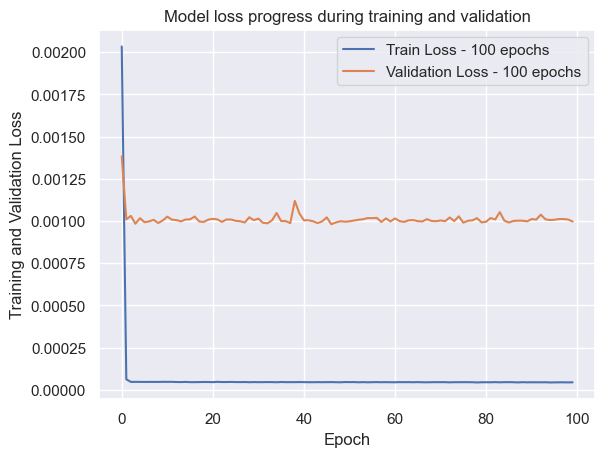

60/60 [==============================] - 0s 1ms/step
Train Score: 16.15 RMSE for 100 epochs
Test Score: 72.66 RMSE for 100 epochs
     Train RMSE  Test RMSE
10    15.833777  72.772595
30    15.517521  72.650855
50    23.813565  76.890345
100   16.147854  72.655265


In [177]:
# Normalize dataset for LSTM
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(df_interpolated['RATE'].values.reshape(-1,1))

# Split into train and test sets
train_size = int(len(dataset) * 0.7)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

# Reshape into X=t and Y=t+1, timestep  look_back
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# Reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

# Number of epochs for training
epochs_list = [10, 30, 50, 100]

rmse_results = {}

for epochs in epochs_list:
    print(f'Training for {epochs} epochs...')
    model, history = create_LSTM_model(trainX, trainY, testX, testY, epochs)
    
    # Add the loss for this model to the plot
    plt.plot(history.history['loss'], label=f'Train Loss - {epochs} epochs')
    plt.plot(history.history['val_loss'], label=f'Validation Loss - {epochs} epochs')

    # Configure and show the plot
    plt.title('Model loss progress during training and validation')
    plt.xlabel('Epoch')
    plt.ylabel('Training and Validation Loss')
    plt.legend()
    plt.show();

    # Evalute LSTM Model
    trainPredict = model.predict(trainX)
    testPredict = model.predict(testX)

    # Invert predictions back to prescaled values
    trainPredict = scaler.inverse_transform(trainPredict)
    trainY_orig = scaler.inverse_transform([trainY])
    testPredict = scaler.inverse_transform(testPredict)
    testY_orig = scaler.inverse_transform([testY])

    # Calculate mean squared error
    trainScore = calculate_RMSE(trainY_orig[0], trainPredict[:,0])
    print(f'Train Score: {trainScore:.2f} RMSE for {epochs} epochs')
    testScore = calculate_RMSE(testY_orig[0], testPredict[:,0])
    print(f'Test Score: {testScore:.2f} RMSE for {epochs} epochs')

    rmse_results[epochs] = {'Train RMSE': trainScore, 'Test RMSE': testScore}

# Convert the dictionary to a DataFrame for easy display
rmse_df = pd.DataFrame(rmse_results).T
print(rmse_df)

# # View how LSTM model fitting to the actual data
# plot_predictions_v1(dataset, trainPredict, testPredict, look_back)